# Self-consistency across ANI cutoffs
> How much do mixture embeddings change as a function of tweaking the ANI cutoffs?

An earlier version of this analysis appears at https://github.com/pchlenski/mixture/blob/main/01_cluster_fidelity.ipynb

Clustering code appears at https://github.com/pchlenski/phylosig/blob/master/09_similarity_cutoff.ipynb

# Generate OTU tables at different clustering cutoffs

In [1]:
# Imports from phylosig git repo
from collections import defaultdict

CUTOFFS = [97, 94, 91, 88, 85, 82, 79, 76, 73, 70, 67, 64, 61]  # Start at 97 because MLRepo is clustered at 97


def parse_similarity_map(n: int, otus_dir="../data/greengenes/otus"):
    """Map cluster --> OTUs"""
    map_path = f"{otus_dir}/{int(n)}_otu_map.txt"
    map_dict = defaultdict(list)
    map_str = open(map_path).read()
    for line in map_str.strip().split("\n"):
        _, cluster_id, *otu_ids = line.split("\t")
        map_dict[cluster_id].extend([cluster_id, *otu_ids])
    return map_dict


def combine_similarity_maps(map_dicts):
    """Map cluster --> OTUs iteratively"""

    # Our first map maps 99% OTUs to 97% OTUs
    # We want to go 99 --> 97 --> 95 --> 94 --> etc...
    # We want to map cluster --> OTUs still

    higher_level_map = map_dicts[0]
    for map_dict in map_dicts[1:]:
        # Generate mapping 99 --> x
        new_map_dict = defaultdict(list)
        for cluster_id, otus in map_dict.items():
            for otu in otus:
                new_map_dict[cluster_id].extend(higher_level_map[otu])
            # for otu in otus:
            #     new_map_dict[cluster_id].extend(higher_level_map[cluster_id])
            #     # Principle: if a later cluster exists, it existed in all
            #     # earlier maps
        higher_level_map = new_map_dict

    return higher_level_map


def merge_otu_table(otu_table, map_dict, drop=True):
    # Pre-filter map_dict to only include OTUs that exist in the table
    filtered_map = {
        cluster_id: [otu for otu in otus if otu in otu_table.columns] for cluster_id, otus in map_dict.items()
    }

    # Only keep clusters that have at least one existing OTU
    filtered_map = {k: v for k, v in filtered_map.items() if v}

    # Create all columns at once to avoid fragmentation
    result_dict = {}
    for cluster_id, existing_otus in filtered_map.items():
        result_dict[cluster_id] = otu_table[existing_otus].sum(axis=1)

    new_otu_table = pd.DataFrame(result_dict, index=otu_table.index)

    if drop and not new_otu_table.empty:
        # Calculate column sums once
        col_sums = new_otu_table.sum(axis=0)
        new_otu_table = new_otu_table.loc[:, col_sums > 0]

    return new_otu_table

In [2]:
import anndata

mlrepo = anndata.read_h5ad("../data/mlrepo5.h5ad")

In [ ]:
# Iterative clustering
import pandas as pd
import biom

otu_df = pd.DataFrame(mlrepo.X, index=mlrepo.obs.index, columns=mlrepo.var.index)

# Kick it off with level 0
similarity_map = parse_similarity_map(CUTOFFS[0])
clustered_biom = biom.Table(data=otu_df.values.T, observation_ids=otu_df.columns, sample_ids=otu_df.index)
with biom.util.biom_open(f"../results/clustered_otu_tables/mlrepo_{CUTOFFS[0]}.biom", "w") as f:
    clustered_biom.to_hdf5(f, f"mlrepo_{x}")
for x in CUTOFFS[1:]:
    similarity_map = combine_similarity_maps([similarity_map, parse_similarity_map(x)])
    clustered = merge_otu_table(otu_df, similarity_map)
    s = clustered.sum(axis=1)
    print(f"{x} {clustered.shape} {s.min():.3f} {s.mean():.3f} {s.max():.3f}")
    # clustered.to_csv(f"../results/clustered_otu_tables/mlrepo_{x}.tsv.gz", sep="\t", compression="gzip")
    clustered_biom = biom.Table(data=clustered.values.T, observation_ids=clustered.columns, sample_ids=clustered.index)
    with biom.util.biom_open(f"../results/clustered_otu_tables/mlrepo_{x}.biom", "w") as f:
        clustered_biom.to_hdf5(f, f"mlrepo_{x}")

94 (10037, 13968) 1.000 1.000 1.000
91 (10037, 6525) 1.000 1.000 1.000
88 (10037, 3160) 1.000 1.000 1.000
85 (10037, 1540) 1.000 1.000 1.000
82 (10037, 795) 1.000 1.000 1.000
79 (10037, 414) 1.000 1.000 1.000
76 (10037, 219) 1.000 1.000 1.000
73 (10037, 115) 1.000 1.000 1.000
70 (10037, 54) 1.000 1.000 1.000
67 (10037, 24) 1.000 1.000 1.000
64 (10037, 15) 1.000 1.000 1.000
61 (10037, 11) 1.000 1.000 1.000


# Compute self-consistency for each metric

97 94 91 88 85 82 79 76 73 70 67 64 61 
97 94 91 88 85 82 79 76 73 70 67 64 61 
97 94 91 88 85 82 79 76 73 70 67 64 61 


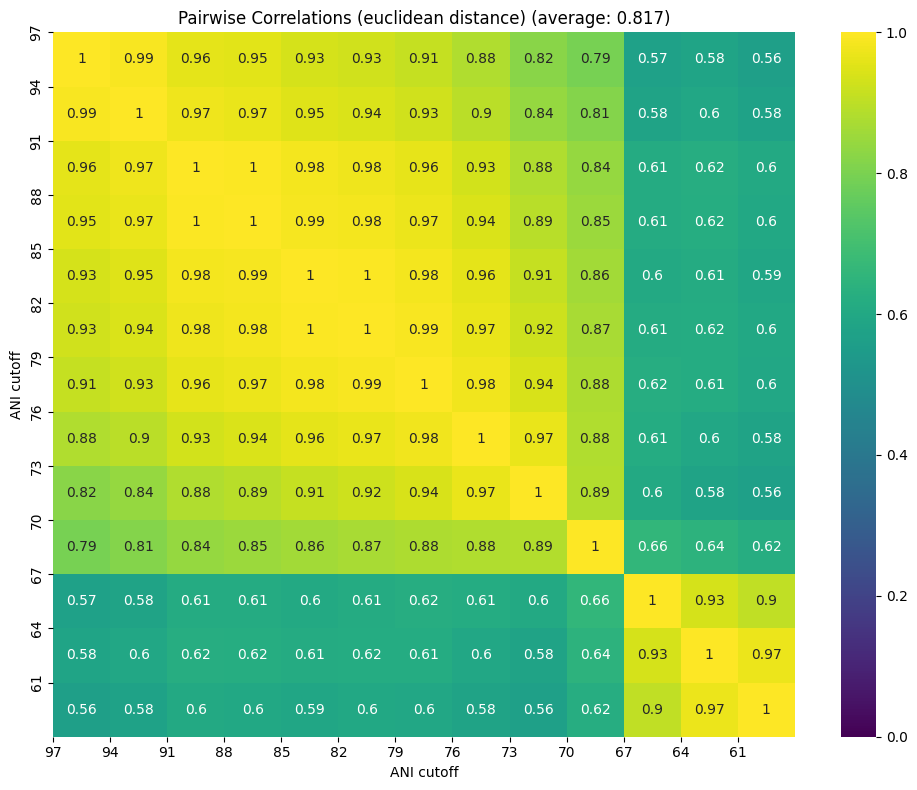

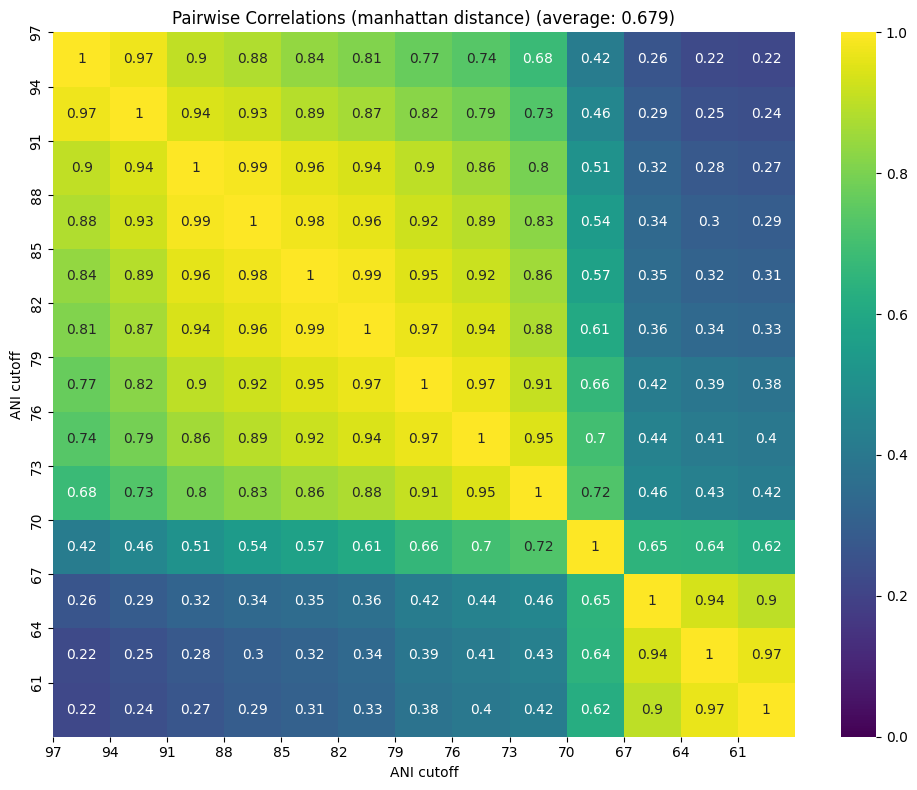

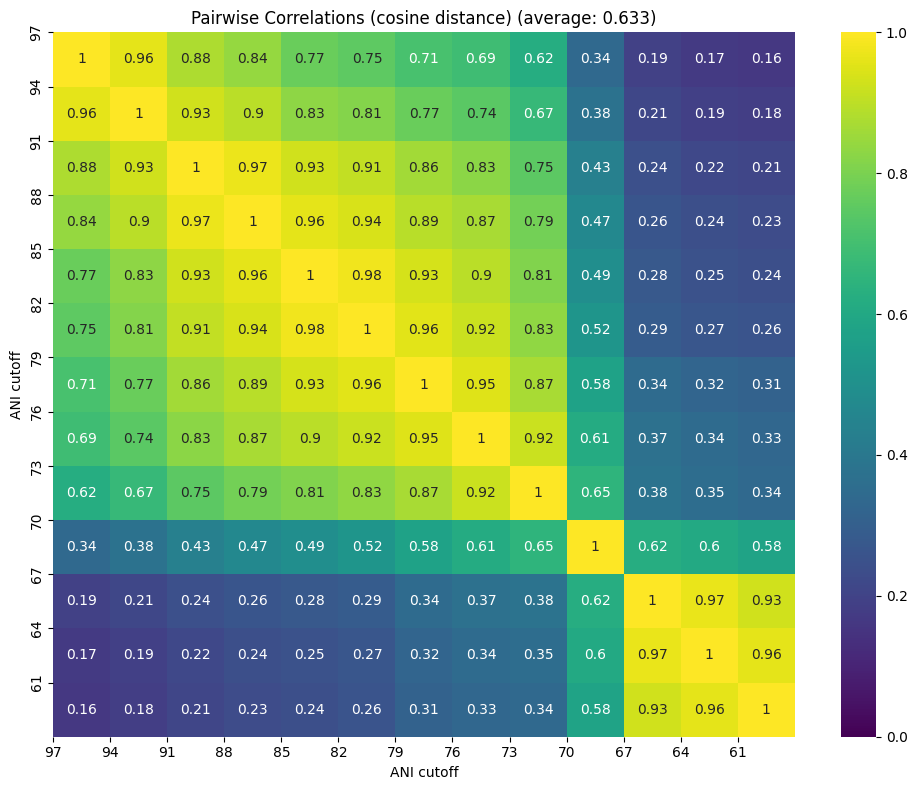

In [ ]:
from sklearn.metrics import pairwise_distances
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import biom


def get_pairwise_distances(metric):
    # Aggregate pairwise distances across all clusters into a dataframe
    print(CUTOFFS[0], end=" ")
    all_dists = [pairwise_distances(mlrepo.X, metric=metric)]
    for x in CUTOFFS[1:]:
        print(x, end=" ")
        biom_table = biom.load_table(f"../results/clustered_otu_tables/mlrepo_{x}.biom")
        biom_table_np = np.asarray(biom_table.matrix_data.todense().T)  # Hell of a conversion lol
        dists = pairwise_distances(biom_table_np, metric=metric, n_jobs=-1)
        all_dists.append(dists)
    print()

    return all_dists


def get_pairwise_correlations(all_dists):
    corrs = np.zeros((len(CUTOFFS), len(CUTOFFS)))
    for i in range(len(CUTOFFS)):
        dist1 = all_dists[i][np.triu_indices(len(mlrepo.obs.index), k=1)]
        for j in range(i):
            dist2 = all_dists[j][np.triu_indices(len(mlrepo.obs.index), k=1)]
            corrs[i, j] = np.corrcoef(dist1, dist2)[0, 1]
    corrs = corrs + corrs.T
    np.fill_diagonal(corrs, 1)

    return corrs


def plot_pairwise_correlations(corrs, metric):
    fig = plt.figure(figsize=(10, 8))
    sns.heatmap(corrs, annot=True, cmap="viridis", vmin=0, vmax=1, center=0.5)
    plt.title(f"Pairwise Correlations ({metric} distance) (average: {corrs.mean():.3f})")
    plt.xticks(range(len(CUTOFFS)), [str(x) for x in CUTOFFS])
    plt.yticks(range(len(CUTOFFS)), [str(x) for x in CUTOFFS])
    plt.xlabel("ANI cutoff")
    plt.ylabel("ANI cutoff")
    plt.tight_layout()

    return fig


def make_pairwise_correlations_plot(metric):
    all_dists = get_pairwise_distances(metric)
    corrs = get_pairwise_correlations(all_dists)
    plot = plot_pairwise_correlations(corrs, metric)
    return all_dists, corrs, plot


for metric in ["euclidean", "manhattan", "cosine"]:
    _, corrs, plot = make_pairwise_correlations_plot(metric)
    corrs_df = pd.DataFrame(corrs, index=CUTOFFS, columns=CUTOFFS)
    corrs_df.to_csv(f"../results/ani_corrs/{metric}.csv")
    plt.savefig(f"../figures/{metric}_ani_correlations.pdf", dpi=300, bbox_inches="tight")

In [20]:
%%bash

# Compute unifrac forwith "ssu", which can be found at https://github.com/biocore/unifrac-binaries
# For all subsampled matrices

export UNIFRAC_GPU_INFO=Y

unifrac_path="/home/phil/miniconda3/envs/unifrac/bin/ssu"
# Create output directory if it doesn't exist
mkdir -p ../results/clustered_otu_unifrac/

# Loop through all ANI cutoffs
for X in 97 94 91 88 85 82 79 76 73 70 67 64 61; do
    biom_path="../results/clustered_otu_tables/mlrepo_${X}.biom"
    tree_path="../data/greengenes/trees/99_otus.tree"
    out_path_unweighted="../results/clustered_otu_unifrac/unweighted_unifrac_${X}.tsv"
    out_path_weighted="../results/clustered_otu_unifrac/weighted_unifrac_${X}.tsv"
    
    echo "Processing ANI cutoff ${X}..."
    
    if [ ! -f ${out_path_unweighted}.gz ]; then
        $unifrac_path -i $biom_path -o $out_path_unweighted -m unweighted -t $tree_path
        echo "done - unweighted for ANI ${X}"
        gzip -f $out_path_unweighted
        echo "done - unweighted for ANI ${X}; gzipped"
    fi
    
    if [ ! -f ${out_path_weighted}.gz ]; then
        $unifrac_path -i $biom_path -o $out_path_weighted -m weighted_normalized -t $tree_path
        echo "done - weighted for ANI ${X}"
        gzip -f $out_path_weighted
        echo "done - weighted for ANI ${X}; gzipped"
    fi
done

Processing ANI cutoff 97...
INFO (unifrac): Using GPU
done - unweighted for ANI 97
done - unweighted for ANI 97; gzipped
INFO (unifrac): Using GPU
done - weighted for ANI 97
done - weighted for ANI 97; gzipped
Processing ANI cutoff 94...
INFO (unifrac): Using GPU
done - unweighted for ANI 94
done - unweighted for ANI 94; gzipped
INFO (unifrac): Using GPU
done - weighted for ANI 94
done - weighted for ANI 94; gzipped
Processing ANI cutoff 91...
INFO (unifrac): Using GPU
done - unweighted for ANI 91
done - unweighted for ANI 91; gzipped
INFO (unifrac): Using GPU
done - weighted for ANI 91
done - weighted for ANI 91; gzipped
Processing ANI cutoff 88...
INFO (unifrac): Using GPU
done - unweighted for ANI 88
done - unweighted for ANI 88; gzipped
INFO (unifrac): Using GPU
done - weighted for ANI 88
done - weighted for ANI 88; gzipped
Processing ANI cutoff 85...
INFO (unifrac): Using GPU
done - unweighted for ANI 85
done - unweighted for ANI 85; gzipped
INFO (unifrac): Using GPU
done - weight

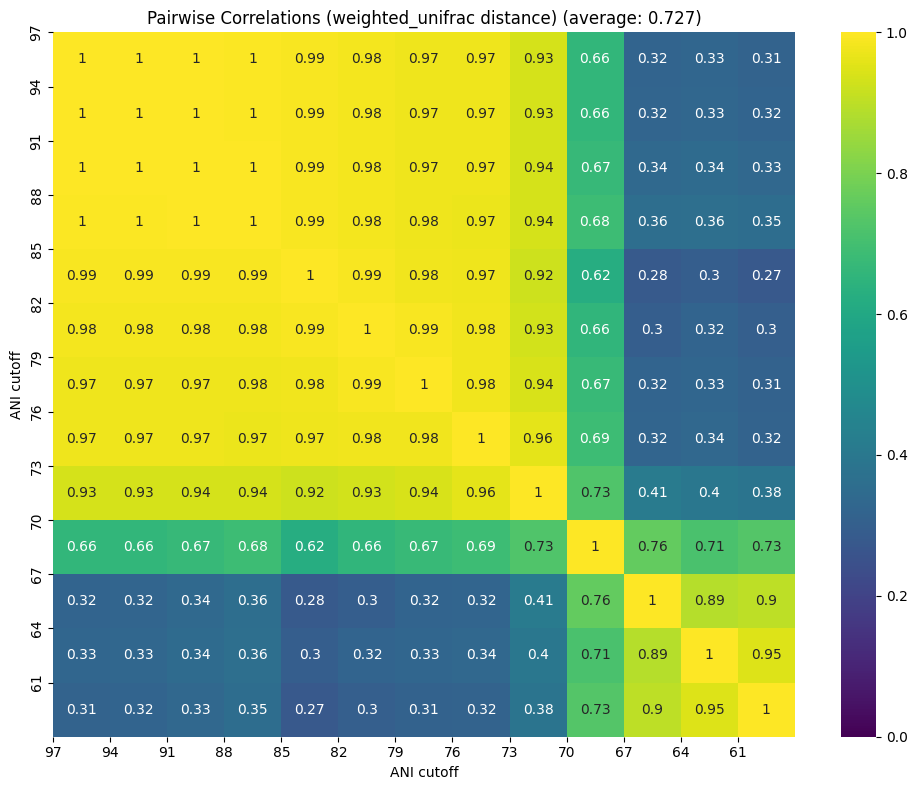

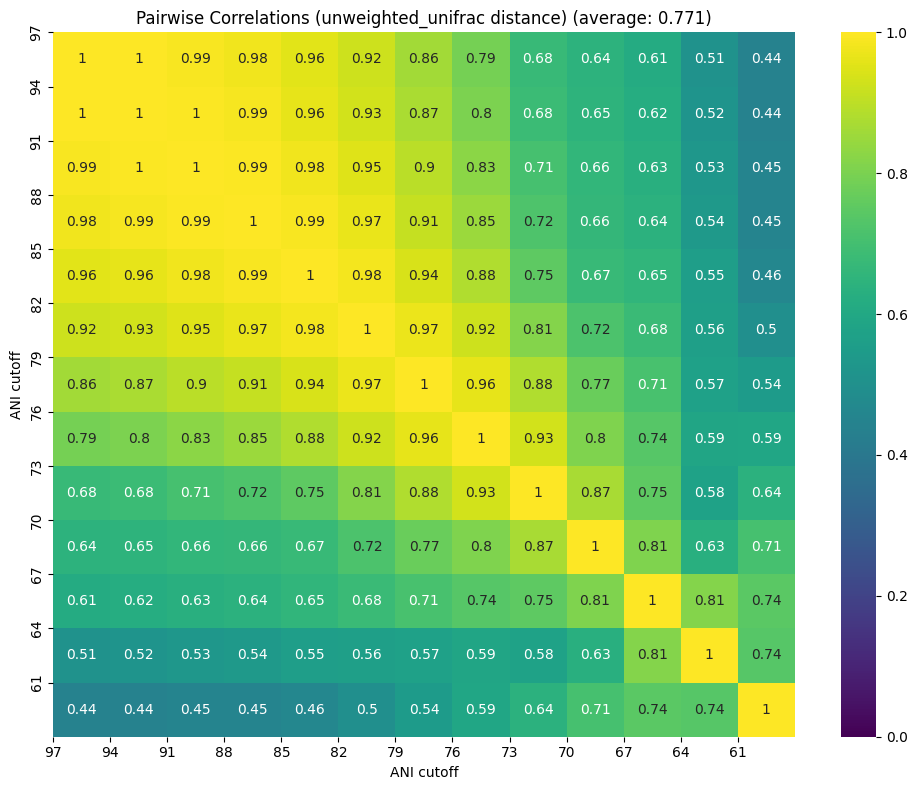

In [26]:
def get_pairwise_distances_unifrac(metric):
    # return all_dists
    all_dists = []
    for cutoff in CUTOFFS:
        # dists = pd.read_table(f"../results/{metric}.tsv.gz", sep="\t", index_col=0)
        dists = pd.read_table(f"../results/clustered_otu_unifrac/{metric}_{cutoff}.tsv.gz", sep="\t", index_col=0)
        dists = dists.loc[mlrepo.obs.index, mlrepo.obs.index]
        dists = dists.values
        all_dists.append(dists)
    
    return all_dists

for metric in ["weighted_unifrac", "unweighted_unifrac"]:
    all_dists = get_pairwise_distances_unifrac(metric)
    corrs = get_pairwise_correlations(all_dists)
    plot = plot_pairwise_correlations(corrs, metric)
    corrs_df = pd.DataFrame(corrs, index=CUTOFFS, columns=CUTOFFS)
    corrs_df.to_csv(f"../results/ani_corrs/{metric}.csv")
    plt.savefig(f"../figures/{metric}_ani_correlations.pdf", dpi=300, bbox_inches="tight")

# Really big mixture embeddings grid

In [2]:
import anndata 

mlrepo = anndata.read_h5ad("../data/mlrepo5.h5ad")

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import biom
import torch
import geoopt
import os
import gc
from tqdm import tqdm
from scipy.spatial.distance import pdist, squareform
import gzip
from transformers import AutoTokenizer, AutoModel
from Bio import SeqIO

# Define constants
CUTOFFS = [97, 94, 91, 88, 85, 82, 79, 76, 73, 70, 67, 64, 61]
DEVICE = "cuda"  # Using GPU for calculations
MAN = geoopt.manifolds.PoincareBall().to(DEVICE)

# Create directories for storing results
os.makedirs("../results/clustered_otu_dists", exist_ok=True)
os.makedirs("../results/ani_corrs", exist_ok=True)
os.makedirs("../figures", exist_ok=True)

# Get all embedding types to process
embedding_types = []
for geom in ["H", "E"]:
    for dim in [2, 4, 8, 16, 32, 64, 128]:
        embedding_types.append(f"{geom}{dim}")
embedding_types.append("dnabert-s")

total_computations = len(embedding_types) * len(CUTOFFS)
completed_computations = 0

# Count completed computations first to provide accurate progress reporting
print("Checking for already completed computations...")
for emb_type in embedding_types:
    emb_dir = f"../results/clustered_otu_dists/{emb_type}"
    if os.path.exists(emb_dir):
        for cutoff in CUTOFFS:
            dist_path = f"{emb_dir}/cutoff_{cutoff}.npy"
            if os.path.exists(dist_path):
                completed_computations += 1

print(f"Found {completed_computations} completed computations out of {total_computations}")
print(f"Starting analysis for {len(embedding_types)} embedding types across {len(CUTOFFS)} ANI cutoffs ({total_computations} total computations)")

# For DNABERT-S, initialize model once
if "dnabert-s" in embedding_types:
    print("Initializing DNABERT-S model...")
    try:
        dnabert_tokenizer = AutoTokenizer.from_pretrained("zhihan1996/DNABERT-S", trust_remote_code=True)
        dnabert_model = AutoModel.from_pretrained("zhihan1996/DNABERT-S", trust_remote_code=True)
        dnabert_model.eval()
        dnabert_model = dnabert_model.to(DEVICE)
        
        # Function to compute DNABERT-S embeddings
        def compute_dnabert_embedding(seq):
            """Mean-pooled embedding of the entire sequence"""
            with torch.no_grad():
                inputs = dnabert_tokenizer(seq, return_tensors="pt")["input_ids"].to(DEVICE)
                hidden_states = dnabert_model(inputs)[0]  # (1, seq_length, 768)
                embedding_mean = hidden_states[0].mean(dim=0)  # (768,)
            return embedding_mean.cpu().numpy()
        
        # Load the FASTA file - will be needed for DNABERT-S embeddings
        print("Loading Greengenes FASTA file...")
        gg_fasta_path = "../data/greengenes/gg_13_5.fasta.gz"
        gg_fasta = {rec.id: str(rec.seq) for rec in SeqIO.parse(gzip.open(gg_fasta_path, "rt"), format="fasta")}
        print(f"Loaded {len(gg_fasta)} FASTA sequences")
        
    except Exception as e:
        print(f"Error initializing DNABERT-S: {e}")
        # Remove dnabert-s from embeddings to process if we can't initialize it
        if "dnabert-s" in embedding_types:
            embedding_types.remove("dnabert-s")
            print("Removed dnabert-s from embedding types to process")

# Process each embedding type
for emb_idx, emb_type in enumerate(embedding_types):
    print(f"\nProcessing embedding type: {emb_type} ({emb_idx+1}/{len(embedding_types)})")
    
    # Create directory for this embedding type
    emb_dir = f"../results/clustered_otu_dists/{emb_type}"
    os.makedirs(emb_dir, exist_ok=True)
    
    # Check if all cutoffs for this embedding type are already done
    all_cutoffs_done = True
    for cutoff in CUTOFFS:
        if not os.path.exists(f"{emb_dir}/cutoff_{cutoff}.npy"):
            all_cutoffs_done = False
            break
    
    if all_cutoffs_done:
        print(f"  SKIPPING: All cutoffs already processed for {emb_type}")
        continue
    
    # Process each cutoff
    for cutoff_idx, cutoff in enumerate(CUTOFFS):
        # Path to save the distance matrix
        dist_path = f"{emb_dir}/cutoff_{cutoff}.npy"
        
        # Check if already computed
        if os.path.exists(dist_path):
            print(f"  SKIPPING: Cutoff {cutoff} ({cutoff_idx+1}/{len(CUTOFFS)}) - already computed")
            continue
        
        print(f"\nProcessing cutoff {cutoff} ({cutoff_idx+1}/{len(CUTOFFS)}) - Overall progress: {completed_computations}/{total_computations} ({completed_computations/total_computations*100:.1f}%)")
        
        if cutoff == 97 and emb_type in mlrepo.obsp:  # First cutoff - load from mlrepo.obsp if available
            print(f"  Loading distances from mlrepo.obsp['{emb_type}']")
            dists = mlrepo.obsp[emb_type].copy()
            
            # Save to file
            np.save(dist_path, dists)
            completed_computations += 1
            continue
            
        # Load BIOM table for this cutoff
        biom_path = f"../results/clustered_otu_tables/mlrepo_{cutoff}.biom"
        print(f"  Loading BIOM table from {biom_path}")
        biom_table = biom.load_table(biom_path)
        
        # Get abundance data - note that BIOM tables are transposed compared to anndata
        # BIOM is (features, samples) while anndata is (samples, features)
        biom_data = np.asarray(biom_table.matrix_data.todense())  # This will be (features, samples)
        
        # Get feature IDs from the BIOM table
        biom_features = list(biom_table.ids('observation'))
        print(f"  BIOM feature count: {len(biom_features)}")

        # Load embeddings based on embedding type
        if emb_type.startswith('E') or emb_type.startswith('H'):
            # Determine geometry and dimension
            geom = emb_type[0]
            dim = emb_type[1:]
            
            # Load embeddings from file
            embedding_path = f"../data/otu_embeddings/greengenes/{geom}{dim}.csv.gz"
            print(f"  Loading embeddings from {embedding_path}")
            
            try:
                # Load embeddings - index by OTU IDs
                embeddings_df = pd.read_csv(embedding_path, index_col=1)
                if "Unnamed: 0.1" in embeddings_df.columns:
                    embeddings_df = embeddings_df.drop(columns=["Unnamed: 0.1"])
                
                # Convert indices to strings
                embeddings_df.index = [str(x) for x in embeddings_df.index]
                
                # Check which features have embeddings
                valid_features = []
                for feature in biom_features:
                    if feature in embeddings_df.index:
                        valid_features.append(feature)
                
                print(f"  Found {len(valid_features)}/{len(biom_features)} features with embeddings")
                
                if len(valid_features) == 0:
                    print("  ERROR: No matching features with embeddings. Cannot proceed.")
                    continue
                
                # Get embeddings for valid features
                feature_embeddings = np.array([embeddings_df.loc[f].values for f in valid_features])
                
                # Get indices of valid features in the BIOM data
                valid_feature_indices = [biom_features.index(f) for f in valid_features]
                biom_data_filtered = biom_data[valid_feature_indices]
                
                # Transpose to get (samples, features)
                biom_data_filtered = biom_data_filtered.T
                
                # Calculate mixture embeddings
                if emb_type.startswith('H'):  # Hyperbolic case
                    print(f"  Generating hyperbolic mixture embeddings for {emb_type}")
                    
                    try:
                        abundances_tensor = torch.tensor(biom_data_filtered, device=DEVICE)
                        embeddings_tensor = torch.tensor(feature_embeddings, device=DEVICE).unsqueeze(0)
                        
                        if int(dim) == 128:  # Special case for H128
                            print(f"  Computing H128 embeddings using iterative approach...")
                            out = [MAN.weighted_midpoint(embeddings_tensor, row).cpu().numpy() 
                                   for row in tqdm(abundances_tensor)]
                            out = np.array(out)
                        else:
                            print(f"  Computing {emb_type} embeddings using vectorized approach...")
                            out = (
                                MAN.weighted_midpoint(xs=embeddings_tensor, weights=abundances_tensor, reducedim=[1])
                                .detach().cpu().numpy()
                            )
                        
                        # Clear CUDA memory
                        del abundances_tensor, embeddings_tensor
                        torch.cuda.empty_cache()
                        gc.collect()
                        
                        # Compute pairwise distances using the hyperbolic metric
                        print(f"  Computing pairwise distances using Poincaré metric...")
                        points = torch.tensor(out, device=DEVICE)
                        n = points.shape[0]
                        dists = torch.zeros((n, n), device=DEVICE)
                        
                        batch_size = 128  # Process in batches to avoid CUDA OOM
                        for i in tqdm(range(0, n, batch_size)):
                            end_idx = min(i + batch_size, n)
                            batch_points = points[i:end_idx]
                            for j, point in enumerate(batch_points):
                                x = point.unsqueeze(0).expand(n, -1)
                                dists[i+j] = MAN.dist(x, points)
                            
                            # Clear memory after each batch
                            torch.cuda.empty_cache()
                            gc.collect()
                        
                        dists = dists.cpu().numpy()
                        
                        # Clear CUDA memory again
                        del points
                        torch.cuda.empty_cache()
                        gc.collect()
                        
                    except RuntimeError as e:
                        if 'CUDA out of memory' in str(e):
                            print(f"  CUDA OOM Error: {str(e)}")
                            print("  Falling back to CPU for this computation...")
                            
                            # Clear CUDA memory
                            if 'abundances_tensor' in locals(): del abundances_tensor
                            if 'embeddings_tensor' in locals(): del embeddings_tensor
                            if 'points' in locals(): del points
                            torch.cuda.empty_cache()
                            gc.collect()
                            
                            # Try again on CPU
                            DEVICE_BACKUP = "cpu"
                            MAN_CPU = geoopt.manifolds.PoincareBall().to(DEVICE_BACKUP)
                            
                            abundances_tensor = torch.tensor(biom_data_filtered, device=DEVICE_BACKUP)
                            embeddings_tensor = torch.tensor(feature_embeddings, device=DEVICE_BACKUP).unsqueeze(0)
                            
                            if int(dim) == 128:
                                print(f"  Computing H128 embeddings on CPU (this may be slow)...")
                                out = [MAN_CPU.weighted_midpoint(embeddings_tensor, row).numpy() 
                                       for row in tqdm(abundances_tensor)]
                                out = np.array(out)
                            else:
                                print(f"  Computing {emb_type} embeddings on CPU...")
                                out = (
                                    MAN_CPU.weighted_midpoint(xs=embeddings_tensor, weights=abundances_tensor, reducedim=[1])
                                    .detach().numpy()
                                )
                            
                            # Calculate distances on CPU (much slower but no memory issues)
                            print(f"  Computing pairwise distances on CPU...")
                            n = out.shape[0]
                            dists = np.zeros((n, n))
                            
                            points = torch.tensor(out, device=DEVICE_BACKUP)
                            for i in tqdm(range(n)):
                                x = points[i].unsqueeze(0).expand(n, -1)
                                dists[i] = MAN_CPU.dist(x, points).numpy()
                        else:
                            raise
                
                elif emb_type.startswith('E'):  # Euclidean case
                    print(f"  Generating Euclidean mixture embeddings for {emb_type}")
                    
                    try:
                        # Generate mixture embeddings
                        out = biom_data_filtered @ feature_embeddings
                        
                        # Compute pairwise distances using Euclidean metric
                        print(f"  Computing pairwise Euclidean distances...")
                        dists = squareform(pdist(out, metric="euclidean"))
                        
                    except MemoryError:
                        print(f"  Memory Error: Falling back to batch processing...")
                        
                        # Generate embeddings
                        out = biom_data_filtered @ feature_embeddings
                        
                        # Compute distances in batches
                        n = out.shape[0]
                        dists = np.zeros((n, n))
                        
                        batch_size = 1000  # Adjust based on your memory constraints
                        for i in tqdm(range(0, n, batch_size)):
                            end_idx = min(i + batch_size, n)
                            batch = out[i:end_idx]
                            for j in range(n):
                                dists[i:end_idx, j] = np.sqrt(np.sum((batch - out[j])**2, axis=1))
                        
                        # Make symmetric
                        dists = (dists + dists.T) / 2
                
            except Exception as e:
                print(f"  Error processing embeddings: {str(e)}")
                continue
                
        elif emb_type == "dnabert-s":
            print(f"  Generating DNABERT-S embeddings")
            
            try:
                # Check which features have FASTA sequences
                valid_features = []
                for feature in biom_features:
                    if feature in gg_fasta:
                        valid_features.append(feature)
                
                print(f"  Found {len(valid_features)}/{len(biom_features)} features with FASTA sequences")
                
                if len(valid_features) == 0:
                    print("  ERROR: No matching features with FASTA sequences. Cannot proceed.")
                    continue
                
                # Get indices of valid features in the BIOM data
                valid_feature_indices = [biom_features.index(f) for f in valid_features]
                biom_data_filtered = biom_data[valid_feature_indices]
                
                # Transpose to get (samples, features)
                biom_data_filtered = biom_data_filtered.T
                
                # Compute DNABERT-S embeddings for each valid feature
                print("  Computing DNABERT-S embeddings for features...")
                feature_embeddings = []
                for feature in tqdm(valid_features):
                    seq = gg_fasta[feature]
                    embedding = compute_dnabert_embedding(seq)
                    feature_embeddings.append(embedding)
                
                feature_embeddings = np.array(feature_embeddings)
                
                # Generate mixture embeddings
                print("  Generating mixture embeddings...")
                out = biom_data_filtered @ feature_embeddings
                
                # Compute pairwise distances using Euclidean metric
                print(f"  Computing pairwise Euclidean distances...")
                dists = squareform(pdist(out, metric="euclidean"))
                
            except Exception as e:
                print(f"  Error processing DNABERT-S embeddings: {str(e)}")
                continue
        
        # Save distance matrix to file
        print(f"  Saving distance matrix to {dist_path}")
        np.save(dist_path, dists)
        
        # Update completed count
        completed_computations += 1
        
        # Clear any remaining variables to free memory
        if 'biom_data' in locals(): del biom_data
        if 'biom_data_filtered' in locals(): del biom_data_filtered
        if 'biom_table' in locals(): del biom_table
        if 'feature_embeddings' in locals(): del feature_embeddings
        if 'embeddings_df' in locals(): del embeddings_df
        if 'out' in locals(): del out
        if 'dists' in locals(): del dists
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Compute correlations and generate plots for each embedding type
print("\nComputing correlations and generating plots...")
for emb_idx, emb_type in enumerate(embedding_types):
    csv_path = f"../results/ani_corrs/{emb_type}.csv"
    plot_path = f"../figures/{emb_type}_ani_correlations.pdf"
    
    # Skip if both CSV and plot already exist
    if os.path.exists(csv_path) and os.path.exists(plot_path):
        print(f"\nSKIPPING correlation analysis for {emb_type} ({emb_idx+1}/{len(embedding_types)}) - files already exist")
        continue
        
    print(f"\nProcessing correlations for {emb_type} ({emb_idx+1}/{len(embedding_types)})")
    
    # Check if all distance files exist
    all_files_exist = True
    for cutoff in CUTOFFS:
        dist_path = f"../results/clustered_otu_dists/{emb_type}/cutoff_{cutoff}.npy"
        if not os.path.exists(dist_path):
            print(f"  Missing distance file: {dist_path}")
            all_files_exist = False
            break
            
    if not all_files_exist:
        print(f"  SKIPPING: Not all distance files exist for {emb_type}")
        continue
    
    # Load distance matrices for all cutoffs
    distances = []
    for cutoff in CUTOFFS:
        dist_path = f"../results/clustered_otu_dists/{emb_type}/cutoff_{cutoff}.npy"
        print(f"  Loading distances from {dist_path}")
        dists = np.load(dist_path)
        distances.append(dists)
    
    # Compute correlations
    print("  Computing correlation matrix...")
    corrs = np.zeros((len(CUTOFFS), len(CUTOFFS)))
    
    for i in range(len(CUTOFFS)):
        dist1 = distances[i][np.triu_indices(len(mlrepo.obs.index), k=1)]
        for j in range(i):
            dist2 = distances[j][np.triu_indices(len(mlrepo.obs.index), k=1)]
            corrs[i, j] = np.corrcoef(dist1, dist2)[0, 1]
    
    # Fill the upper triangle and diagonal
    corrs = corrs + corrs.T
    np.fill_diagonal(corrs, 1)
    
    # Create DataFrame and save to CSV
    corrs_df = pd.DataFrame(corrs, index=CUTOFFS, columns=CUTOFFS)
    print(f"  Saving correlation matrix to {csv_path}")
    corrs_df.to_csv(csv_path)
    
    # Create plot
    print("  Generating heatmap plot...")
    fig = plt.figure(figsize=(10, 8))
    sns.heatmap(corrs, annot=True, cmap="viridis", vmin=0, vmax=1, center=0.5)
    plt.title(f"Pairwise Correlations ({emb_type} distance) (average: {corrs.mean():.3f})")
    plt.xticks(range(len(CUTOFFS)), [str(x) for x in CUTOFFS])
    plt.yticks(range(len(CUTOFFS)), [str(x) for x in CUTOFFS])
    plt.xlabel("ANI cutoff")
    plt.ylabel("ANI cutoff")
    plt.tight_layout()
    
    # Save plot
    print(f"  Saving plot to {plot_path}")
    plt.savefig(plot_path, dpi=300, bbox_inches="tight")
    plt.close()
    
    # Clear memory
    del distances, corrs, corrs_df
    gc.collect()

print("\nAnalysis complete!")

Checking for already completed computations...
Found 0 completed computations out of 195
Starting analysis for 15 embedding types across 13 ANI cutoffs (195 total computations)
Initializing DNABERT-S model...


/home/phil/.cache/huggingface/modules/transformers_modules/zhihan1996/DNABERT-S/2efd650282ec5d5ab377c787c76ea56b723f6b7c/bert_layers.py:126: UserWarning: Unable to import Triton; defaulting MosaicBERT attention implementation to pytorch (this will reduce throughput when using this model).
  warnings.warn(


Loading Greengenes FASTA file...
Loaded 1262986 FASTA sequences

Processing embedding type: H2 (1/15)

Processing cutoff 97 (1/13) - Overall progress: 0/195 (0.0%)
  Loading distances from mlrepo.obsp['H2']

Processing cutoff 94 (2/13) - Overall progress: 1/195 (0.5%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_94.biom
  BIOM feature count: 13968
  Loading embeddings from ../data/otu_embeddings/greengenes/H2.csv.gz
  Found 13968/13968 features with embeddings
  Generating hyperbolic mixture embeddings for H2
  Computing H2 embeddings using vectorized approach...
  Computing pairwise distances using Poincaré metric...


100%|██████████| 79/79 [00:19<00:00,  4.05it/s]


  Saving distance matrix to ../results/clustered_otu_dists/H2/cutoff_94.npy

Processing cutoff 91 (3/13) - Overall progress: 2/195 (1.0%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_91.biom
  BIOM feature count: 6525
  Loading embeddings from ../data/otu_embeddings/greengenes/H2.csv.gz
  Found 6525/6525 features with embeddings
  Generating hyperbolic mixture embeddings for H2
  Computing H2 embeddings using vectorized approach...
  Computing pairwise distances using Poincaré metric...


100%|██████████| 79/79 [00:20<00:00,  3.77it/s]


  Saving distance matrix to ../results/clustered_otu_dists/H2/cutoff_91.npy

Processing cutoff 88 (4/13) - Overall progress: 3/195 (1.5%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_88.biom
  BIOM feature count: 3160
  Loading embeddings from ../data/otu_embeddings/greengenes/H2.csv.gz
  Found 3160/3160 features with embeddings
  Generating hyperbolic mixture embeddings for H2
  Computing H2 embeddings using vectorized approach...
  Computing pairwise distances using Poincaré metric...


100%|██████████| 79/79 [00:19<00:00,  4.11it/s]


  Saving distance matrix to ../results/clustered_otu_dists/H2/cutoff_88.npy

Processing cutoff 85 (5/13) - Overall progress: 4/195 (2.1%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_85.biom
  BIOM feature count: 1540
  Loading embeddings from ../data/otu_embeddings/greengenes/H2.csv.gz
  Found 1540/1540 features with embeddings
  Generating hyperbolic mixture embeddings for H2
  Computing H2 embeddings using vectorized approach...
  Computing pairwise distances using Poincaré metric...


100%|██████████| 79/79 [00:19<00:00,  4.12it/s]


  Saving distance matrix to ../results/clustered_otu_dists/H2/cutoff_85.npy

Processing cutoff 82 (6/13) - Overall progress: 5/195 (2.6%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_82.biom
  BIOM feature count: 795
  Loading embeddings from ../data/otu_embeddings/greengenes/H2.csv.gz
  Found 795/795 features with embeddings
  Generating hyperbolic mixture embeddings for H2
  Computing H2 embeddings using vectorized approach...
  Computing pairwise distances using Poincaré metric...


100%|██████████| 79/79 [00:19<00:00,  4.06it/s]


  Saving distance matrix to ../results/clustered_otu_dists/H2/cutoff_82.npy

Processing cutoff 79 (7/13) - Overall progress: 6/195 (3.1%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_79.biom
  BIOM feature count: 414
  Loading embeddings from ../data/otu_embeddings/greengenes/H2.csv.gz
  Found 414/414 features with embeddings
  Generating hyperbolic mixture embeddings for H2
  Computing H2 embeddings using vectorized approach...
  Computing pairwise distances using Poincaré metric...


100%|██████████| 79/79 [00:19<00:00,  4.03it/s]


  Saving distance matrix to ../results/clustered_otu_dists/H2/cutoff_79.npy

Processing cutoff 76 (8/13) - Overall progress: 7/195 (3.6%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_76.biom
  BIOM feature count: 219
  Loading embeddings from ../data/otu_embeddings/greengenes/H2.csv.gz
  Found 219/219 features with embeddings
  Generating hyperbolic mixture embeddings for H2
  Computing H2 embeddings using vectorized approach...
  Computing pairwise distances using Poincaré metric...


100%|██████████| 79/79 [00:21<00:00,  3.69it/s]


  Saving distance matrix to ../results/clustered_otu_dists/H2/cutoff_76.npy

Processing cutoff 73 (9/13) - Overall progress: 8/195 (4.1%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_73.biom
  BIOM feature count: 115
  Loading embeddings from ../data/otu_embeddings/greengenes/H2.csv.gz
  Found 115/115 features with embeddings
  Generating hyperbolic mixture embeddings for H2
  Computing H2 embeddings using vectorized approach...
  Computing pairwise distances using Poincaré metric...


100%|██████████| 79/79 [00:21<00:00,  3.66it/s]


  Saving distance matrix to ../results/clustered_otu_dists/H2/cutoff_73.npy

Processing cutoff 70 (10/13) - Overall progress: 9/195 (4.6%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_70.biom
  BIOM feature count: 54
  Loading embeddings from ../data/otu_embeddings/greengenes/H2.csv.gz
  Found 54/54 features with embeddings
  Generating hyperbolic mixture embeddings for H2
  Computing H2 embeddings using vectorized approach...
  Computing pairwise distances using Poincaré metric...


100%|██████████| 79/79 [00:21<00:00,  3.76it/s]


  Saving distance matrix to ../results/clustered_otu_dists/H2/cutoff_70.npy

Processing cutoff 67 (11/13) - Overall progress: 10/195 (5.1%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_67.biom
  BIOM feature count: 24
  Loading embeddings from ../data/otu_embeddings/greengenes/H2.csv.gz
  Found 24/24 features with embeddings
  Generating hyperbolic mixture embeddings for H2
  Computing H2 embeddings using vectorized approach...
  Computing pairwise distances using Poincaré metric...


100%|██████████| 79/79 [00:19<00:00,  4.04it/s]


  Saving distance matrix to ../results/clustered_otu_dists/H2/cutoff_67.npy

Processing cutoff 64 (12/13) - Overall progress: 11/195 (5.6%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_64.biom
  BIOM feature count: 15
  Loading embeddings from ../data/otu_embeddings/greengenes/H2.csv.gz
  Found 15/15 features with embeddings
  Generating hyperbolic mixture embeddings for H2
  Computing H2 embeddings using vectorized approach...
  Computing pairwise distances using Poincaré metric...


100%|██████████| 79/79 [00:19<00:00,  4.12it/s]


  Saving distance matrix to ../results/clustered_otu_dists/H2/cutoff_64.npy

Processing cutoff 61 (13/13) - Overall progress: 12/195 (6.2%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_61.biom
  BIOM feature count: 11
  Loading embeddings from ../data/otu_embeddings/greengenes/H2.csv.gz
  Found 11/11 features with embeddings
  Generating hyperbolic mixture embeddings for H2
  Computing H2 embeddings using vectorized approach...
  Computing pairwise distances using Poincaré metric...


100%|██████████| 79/79 [00:19<00:00,  4.12it/s]


  Saving distance matrix to ../results/clustered_otu_dists/H2/cutoff_61.npy

Processing embedding type: H4 (2/15)

Processing cutoff 97 (1/13) - Overall progress: 13/195 (6.7%)
  Loading distances from mlrepo.obsp['H4']

Processing cutoff 94 (2/13) - Overall progress: 14/195 (7.2%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_94.biom
  BIOM feature count: 13968
  Loading embeddings from ../data/otu_embeddings/greengenes/H4.csv.gz
  Found 13968/13968 features with embeddings
  Generating hyperbolic mixture embeddings for H4
  Computing H4 embeddings using vectorized approach...
  Computing pairwise distances using Poincaré metric...


100%|██████████| 79/79 [00:19<00:00,  4.07it/s]


  Saving distance matrix to ../results/clustered_otu_dists/H4/cutoff_94.npy

Processing cutoff 91 (3/13) - Overall progress: 15/195 (7.7%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_91.biom
  BIOM feature count: 6525
  Loading embeddings from ../data/otu_embeddings/greengenes/H4.csv.gz
  Found 6525/6525 features with embeddings
  Generating hyperbolic mixture embeddings for H4
  Computing H4 embeddings using vectorized approach...
  Computing pairwise distances using Poincaré metric...


100%|██████████| 79/79 [00:20<00:00,  3.87it/s]


  Saving distance matrix to ../results/clustered_otu_dists/H4/cutoff_91.npy

Processing cutoff 88 (4/13) - Overall progress: 16/195 (8.2%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_88.biom
  BIOM feature count: 3160
  Loading embeddings from ../data/otu_embeddings/greengenes/H4.csv.gz
  Found 3160/3160 features with embeddings
  Generating hyperbolic mixture embeddings for H4
  Computing H4 embeddings using vectorized approach...
  Computing pairwise distances using Poincaré metric...


100%|██████████| 79/79 [00:20<00:00,  3.88it/s]


  Saving distance matrix to ../results/clustered_otu_dists/H4/cutoff_88.npy

Processing cutoff 85 (5/13) - Overall progress: 17/195 (8.7%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_85.biom
  BIOM feature count: 1540
  Loading embeddings from ../data/otu_embeddings/greengenes/H4.csv.gz
  Found 1540/1540 features with embeddings
  Generating hyperbolic mixture embeddings for H4
  Computing H4 embeddings using vectorized approach...
  Computing pairwise distances using Poincaré metric...


100%|██████████| 79/79 [00:20<00:00,  3.86it/s]


  Saving distance matrix to ../results/clustered_otu_dists/H4/cutoff_85.npy

Processing cutoff 82 (6/13) - Overall progress: 18/195 (9.2%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_82.biom
  BIOM feature count: 795
  Loading embeddings from ../data/otu_embeddings/greengenes/H4.csv.gz
  Found 795/795 features with embeddings
  Generating hyperbolic mixture embeddings for H4
  Computing H4 embeddings using vectorized approach...
  Computing pairwise distances using Poincaré metric...


100%|██████████| 79/79 [00:21<00:00,  3.63it/s]


  Saving distance matrix to ../results/clustered_otu_dists/H4/cutoff_82.npy

Processing cutoff 79 (7/13) - Overall progress: 19/195 (9.7%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_79.biom
  BIOM feature count: 414
  Loading embeddings from ../data/otu_embeddings/greengenes/H4.csv.gz
  Found 414/414 features with embeddings
  Generating hyperbolic mixture embeddings for H4
  Computing H4 embeddings using vectorized approach...
  Computing pairwise distances using Poincaré metric...


100%|██████████| 79/79 [00:21<00:00,  3.65it/s]


  Saving distance matrix to ../results/clustered_otu_dists/H4/cutoff_79.npy

Processing cutoff 76 (8/13) - Overall progress: 20/195 (10.3%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_76.biom
  BIOM feature count: 219
  Loading embeddings from ../data/otu_embeddings/greengenes/H4.csv.gz
  Found 219/219 features with embeddings
  Generating hyperbolic mixture embeddings for H4
  Computing H4 embeddings using vectorized approach...
  Computing pairwise distances using Poincaré metric...


100%|██████████| 79/79 [00:21<00:00,  3.75it/s]


  Saving distance matrix to ../results/clustered_otu_dists/H4/cutoff_76.npy

Processing cutoff 73 (9/13) - Overall progress: 21/195 (10.8%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_73.biom
  BIOM feature count: 115
  Loading embeddings from ../data/otu_embeddings/greengenes/H4.csv.gz
  Found 115/115 features with embeddings
  Generating hyperbolic mixture embeddings for H4
  Computing H4 embeddings using vectorized approach...
  Computing pairwise distances using Poincaré metric...


100%|██████████| 79/79 [00:20<00:00,  3.82it/s]


  Saving distance matrix to ../results/clustered_otu_dists/H4/cutoff_73.npy

Processing cutoff 70 (10/13) - Overall progress: 22/195 (11.3%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_70.biom
  BIOM feature count: 54
  Loading embeddings from ../data/otu_embeddings/greengenes/H4.csv.gz
  Found 54/54 features with embeddings
  Generating hyperbolic mixture embeddings for H4
  Computing H4 embeddings using vectorized approach...
  Computing pairwise distances using Poincaré metric...


100%|██████████| 79/79 [00:19<00:00,  3.96it/s]


  Saving distance matrix to ../results/clustered_otu_dists/H4/cutoff_70.npy

Processing cutoff 67 (11/13) - Overall progress: 23/195 (11.8%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_67.biom
  BIOM feature count: 24
  Loading embeddings from ../data/otu_embeddings/greengenes/H4.csv.gz
  Found 24/24 features with embeddings
  Generating hyperbolic mixture embeddings for H4
  Computing H4 embeddings using vectorized approach...
  Computing pairwise distances using Poincaré metric...


100%|██████████| 79/79 [00:20<00:00,  3.91it/s]


  Saving distance matrix to ../results/clustered_otu_dists/H4/cutoff_67.npy

Processing cutoff 64 (12/13) - Overall progress: 24/195 (12.3%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_64.biom
  BIOM feature count: 15
  Loading embeddings from ../data/otu_embeddings/greengenes/H4.csv.gz
  Found 15/15 features with embeddings
  Generating hyperbolic mixture embeddings for H4
  Computing H4 embeddings using vectorized approach...
  Computing pairwise distances using Poincaré metric...


100%|██████████| 79/79 [00:19<00:00,  4.04it/s]


  Saving distance matrix to ../results/clustered_otu_dists/H4/cutoff_64.npy

Processing cutoff 61 (13/13) - Overall progress: 25/195 (12.8%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_61.biom
  BIOM feature count: 11
  Loading embeddings from ../data/otu_embeddings/greengenes/H4.csv.gz
  Found 11/11 features with embeddings
  Generating hyperbolic mixture embeddings for H4
  Computing H4 embeddings using vectorized approach...
  Computing pairwise distances using Poincaré metric...


100%|██████████| 79/79 [00:19<00:00,  4.05it/s]


  Saving distance matrix to ../results/clustered_otu_dists/H4/cutoff_61.npy

Processing embedding type: H8 (3/15)

Processing cutoff 97 (1/13) - Overall progress: 26/195 (13.3%)
  Loading distances from mlrepo.obsp['H8']

Processing cutoff 94 (2/13) - Overall progress: 27/195 (13.8%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_94.biom
  BIOM feature count: 13968
  Loading embeddings from ../data/otu_embeddings/greengenes/H8.csv.gz
  Found 13968/13968 features with embeddings
  Generating hyperbolic mixture embeddings for H8
  Computing H8 embeddings using vectorized approach...
  Computing pairwise distances using Poincaré metric...


100%|██████████| 79/79 [00:19<00:00,  3.97it/s]


  Saving distance matrix to ../results/clustered_otu_dists/H8/cutoff_94.npy

Processing cutoff 91 (3/13) - Overall progress: 28/195 (14.4%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_91.biom
  BIOM feature count: 6525
  Loading embeddings from ../data/otu_embeddings/greengenes/H8.csv.gz
  Found 6525/6525 features with embeddings
  Generating hyperbolic mixture embeddings for H8
  Computing H8 embeddings using vectorized approach...
  Computing pairwise distances using Poincaré metric...


100%|██████████| 79/79 [00:19<00:00,  4.01it/s]


  Saving distance matrix to ../results/clustered_otu_dists/H8/cutoff_91.npy

Processing cutoff 88 (4/13) - Overall progress: 29/195 (14.9%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_88.biom
  BIOM feature count: 3160
  Loading embeddings from ../data/otu_embeddings/greengenes/H8.csv.gz
  Found 3160/3160 features with embeddings
  Generating hyperbolic mixture embeddings for H8
  Computing H8 embeddings using vectorized approach...
  Computing pairwise distances using Poincaré metric...


100%|██████████| 79/79 [00:19<00:00,  4.02it/s]


  Saving distance matrix to ../results/clustered_otu_dists/H8/cutoff_88.npy

Processing cutoff 85 (5/13) - Overall progress: 30/195 (15.4%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_85.biom
  BIOM feature count: 1540
  Loading embeddings from ../data/otu_embeddings/greengenes/H8.csv.gz
  Found 1540/1540 features with embeddings
  Generating hyperbolic mixture embeddings for H8
  Computing H8 embeddings using vectorized approach...
  Computing pairwise distances using Poincaré metric...


100%|██████████| 79/79 [00:19<00:00,  4.03it/s]


  Saving distance matrix to ../results/clustered_otu_dists/H8/cutoff_85.npy

Processing cutoff 82 (6/13) - Overall progress: 31/195 (15.9%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_82.biom
  BIOM feature count: 795
  Loading embeddings from ../data/otu_embeddings/greengenes/H8.csv.gz
  Found 795/795 features with embeddings
  Generating hyperbolic mixture embeddings for H8
  Computing H8 embeddings using vectorized approach...
  Computing pairwise distances using Poincaré metric...


100%|██████████| 79/79 [00:19<00:00,  4.03it/s]


  Saving distance matrix to ../results/clustered_otu_dists/H8/cutoff_82.npy

Processing cutoff 79 (7/13) - Overall progress: 32/195 (16.4%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_79.biom
  BIOM feature count: 414
  Loading embeddings from ../data/otu_embeddings/greengenes/H8.csv.gz
  Found 414/414 features with embeddings
  Generating hyperbolic mixture embeddings for H8
  Computing H8 embeddings using vectorized approach...
  Computing pairwise distances using Poincaré metric...


100%|██████████| 79/79 [00:19<00:00,  4.03it/s]


  Saving distance matrix to ../results/clustered_otu_dists/H8/cutoff_79.npy

Processing cutoff 76 (8/13) - Overall progress: 33/195 (16.9%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_76.biom
  BIOM feature count: 219
  Loading embeddings from ../data/otu_embeddings/greengenes/H8.csv.gz
  Found 219/219 features with embeddings
  Generating hyperbolic mixture embeddings for H8
  Computing H8 embeddings using vectorized approach...
  Computing pairwise distances using Poincaré metric...


100%|██████████| 79/79 [00:19<00:00,  3.95it/s]


  Saving distance matrix to ../results/clustered_otu_dists/H8/cutoff_76.npy

Processing cutoff 73 (9/13) - Overall progress: 34/195 (17.4%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_73.biom
  BIOM feature count: 115
  Loading embeddings from ../data/otu_embeddings/greengenes/H8.csv.gz
  Found 115/115 features with embeddings
  Generating hyperbolic mixture embeddings for H8
  Computing H8 embeddings using vectorized approach...
  Computing pairwise distances using Poincaré metric...


100%|██████████| 79/79 [00:20<00:00,  3.85it/s]


  Saving distance matrix to ../results/clustered_otu_dists/H8/cutoff_73.npy

Processing cutoff 70 (10/13) - Overall progress: 35/195 (17.9%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_70.biom
  BIOM feature count: 54
  Loading embeddings from ../data/otu_embeddings/greengenes/H8.csv.gz
  Found 54/54 features with embeddings
  Generating hyperbolic mixture embeddings for H8
  Computing H8 embeddings using vectorized approach...
  Computing pairwise distances using Poincaré metric...


100%|██████████| 79/79 [00:20<00:00,  3.87it/s]


  Saving distance matrix to ../results/clustered_otu_dists/H8/cutoff_70.npy

Processing cutoff 67 (11/13) - Overall progress: 36/195 (18.5%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_67.biom
  BIOM feature count: 24
  Loading embeddings from ../data/otu_embeddings/greengenes/H8.csv.gz
  Found 24/24 features with embeddings
  Generating hyperbolic mixture embeddings for H8
  Computing H8 embeddings using vectorized approach...
  Computing pairwise distances using Poincaré metric...


100%|██████████| 79/79 [00:20<00:00,  3.88it/s]


  Saving distance matrix to ../results/clustered_otu_dists/H8/cutoff_67.npy

Processing cutoff 64 (12/13) - Overall progress: 37/195 (19.0%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_64.biom
  BIOM feature count: 15
  Loading embeddings from ../data/otu_embeddings/greengenes/H8.csv.gz
  Found 15/15 features with embeddings
  Generating hyperbolic mixture embeddings for H8
  Computing H8 embeddings using vectorized approach...
  Computing pairwise distances using Poincaré metric...


100%|██████████| 79/79 [00:19<00:00,  4.01it/s]


  Saving distance matrix to ../results/clustered_otu_dists/H8/cutoff_64.npy

Processing cutoff 61 (13/13) - Overall progress: 38/195 (19.5%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_61.biom
  BIOM feature count: 11
  Loading embeddings from ../data/otu_embeddings/greengenes/H8.csv.gz
  Found 11/11 features with embeddings
  Generating hyperbolic mixture embeddings for H8
  Computing H8 embeddings using vectorized approach...
  Computing pairwise distances using Poincaré metric...


100%|██████████| 79/79 [00:19<00:00,  4.01it/s]


  Saving distance matrix to ../results/clustered_otu_dists/H8/cutoff_61.npy

Processing embedding type: H16 (4/15)

Processing cutoff 97 (1/13) - Overall progress: 39/195 (20.0%)
  Loading distances from mlrepo.obsp['H16']

Processing cutoff 94 (2/13) - Overall progress: 40/195 (20.5%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_94.biom
  BIOM feature count: 13968
  Loading embeddings from ../data/otu_embeddings/greengenes/H16.csv.gz
  Found 13968/13968 features with embeddings
  Generating hyperbolic mixture embeddings for H16
  Computing H16 embeddings using vectorized approach...
  Computing pairwise distances using Poincaré metric...


100%|██████████| 79/79 [00:19<00:00,  4.00it/s]


  Saving distance matrix to ../results/clustered_otu_dists/H16/cutoff_94.npy

Processing cutoff 91 (3/13) - Overall progress: 41/195 (21.0%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_91.biom
  BIOM feature count: 6525
  Loading embeddings from ../data/otu_embeddings/greengenes/H16.csv.gz
  Found 6525/6525 features with embeddings
  Generating hyperbolic mixture embeddings for H16
  Computing H16 embeddings using vectorized approach...
  Computing pairwise distances using Poincaré metric...


100%|██████████| 79/79 [00:19<00:00,  4.01it/s]


  Saving distance matrix to ../results/clustered_otu_dists/H16/cutoff_91.npy

Processing cutoff 88 (4/13) - Overall progress: 42/195 (21.5%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_88.biom
  BIOM feature count: 3160
  Loading embeddings from ../data/otu_embeddings/greengenes/H16.csv.gz
  Found 3160/3160 features with embeddings
  Generating hyperbolic mixture embeddings for H16
  Computing H16 embeddings using vectorized approach...
  Computing pairwise distances using Poincaré metric...


100%|██████████| 79/79 [00:20<00:00,  3.80it/s]


  Saving distance matrix to ../results/clustered_otu_dists/H16/cutoff_88.npy

Processing cutoff 85 (5/13) - Overall progress: 43/195 (22.1%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_85.biom
  BIOM feature count: 1540
  Loading embeddings from ../data/otu_embeddings/greengenes/H16.csv.gz
  Found 1540/1540 features with embeddings
  Generating hyperbolic mixture embeddings for H16
  Computing H16 embeddings using vectorized approach...
  Computing pairwise distances using Poincaré metric...


100%|██████████| 79/79 [00:21<00:00,  3.66it/s]


  Saving distance matrix to ../results/clustered_otu_dists/H16/cutoff_85.npy

Processing cutoff 82 (6/13) - Overall progress: 44/195 (22.6%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_82.biom
  BIOM feature count: 795
  Loading embeddings from ../data/otu_embeddings/greengenes/H16.csv.gz
  Found 795/795 features with embeddings
  Generating hyperbolic mixture embeddings for H16
  Computing H16 embeddings using vectorized approach...
  Computing pairwise distances using Poincaré metric...


100%|██████████| 79/79 [00:21<00:00,  3.67it/s]


  Saving distance matrix to ../results/clustered_otu_dists/H16/cutoff_82.npy

Processing cutoff 79 (7/13) - Overall progress: 45/195 (23.1%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_79.biom
  BIOM feature count: 414
  Loading embeddings from ../data/otu_embeddings/greengenes/H16.csv.gz
  Found 414/414 features with embeddings
  Generating hyperbolic mixture embeddings for H16
  Computing H16 embeddings using vectorized approach...
  Computing pairwise distances using Poincaré metric...


100%|██████████| 79/79 [00:20<00:00,  3.78it/s]


  Saving distance matrix to ../results/clustered_otu_dists/H16/cutoff_79.npy

Processing cutoff 76 (8/13) - Overall progress: 46/195 (23.6%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_76.biom
  BIOM feature count: 219
  Loading embeddings from ../data/otu_embeddings/greengenes/H16.csv.gz
  Found 219/219 features with embeddings
  Generating hyperbolic mixture embeddings for H16
  Computing H16 embeddings using vectorized approach...
  Computing pairwise distances using Poincaré metric...


100%|██████████| 79/79 [00:20<00:00,  3.91it/s]


  Saving distance matrix to ../results/clustered_otu_dists/H16/cutoff_76.npy

Processing cutoff 73 (9/13) - Overall progress: 47/195 (24.1%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_73.biom
  BIOM feature count: 115
  Loading embeddings from ../data/otu_embeddings/greengenes/H16.csv.gz
  Found 115/115 features with embeddings
  Generating hyperbolic mixture embeddings for H16
  Computing H16 embeddings using vectorized approach...
  Computing pairwise distances using Poincaré metric...


100%|██████████| 79/79 [00:19<00:00,  4.02it/s]


  Saving distance matrix to ../results/clustered_otu_dists/H16/cutoff_73.npy

Processing cutoff 70 (10/13) - Overall progress: 48/195 (24.6%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_70.biom
  BIOM feature count: 54
  Loading embeddings from ../data/otu_embeddings/greengenes/H16.csv.gz
  Found 54/54 features with embeddings
  Generating hyperbolic mixture embeddings for H16
  Computing H16 embeddings using vectorized approach...
  Computing pairwise distances using Poincaré metric...


100%|██████████| 79/79 [00:19<00:00,  4.03it/s]


  Saving distance matrix to ../results/clustered_otu_dists/H16/cutoff_70.npy

Processing cutoff 67 (11/13) - Overall progress: 49/195 (25.1%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_67.biom
  BIOM feature count: 24
  Loading embeddings from ../data/otu_embeddings/greengenes/H16.csv.gz
  Found 24/24 features with embeddings
  Generating hyperbolic mixture embeddings for H16
  Computing H16 embeddings using vectorized approach...
  Computing pairwise distances using Poincaré metric...


100%|██████████| 79/79 [00:19<00:00,  4.03it/s]


  Saving distance matrix to ../results/clustered_otu_dists/H16/cutoff_67.npy

Processing cutoff 64 (12/13) - Overall progress: 50/195 (25.6%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_64.biom
  BIOM feature count: 15
  Loading embeddings from ../data/otu_embeddings/greengenes/H16.csv.gz
  Found 15/15 features with embeddings
  Generating hyperbolic mixture embeddings for H16
  Computing H16 embeddings using vectorized approach...
  Computing pairwise distances using Poincaré metric...


100%|██████████| 79/79 [00:19<00:00,  4.04it/s]


  Saving distance matrix to ../results/clustered_otu_dists/H16/cutoff_64.npy

Processing cutoff 61 (13/13) - Overall progress: 51/195 (26.2%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_61.biom
  BIOM feature count: 11
  Loading embeddings from ../data/otu_embeddings/greengenes/H16.csv.gz
  Found 11/11 features with embeddings
  Generating hyperbolic mixture embeddings for H16
  Computing H16 embeddings using vectorized approach...
  Computing pairwise distances using Poincaré metric...


100%|██████████| 79/79 [00:19<00:00,  4.04it/s]


  Saving distance matrix to ../results/clustered_otu_dists/H16/cutoff_61.npy

Processing embedding type: H32 (5/15)

Processing cutoff 97 (1/13) - Overall progress: 52/195 (26.7%)
  Loading distances from mlrepo.obsp['H32']

Processing cutoff 94 (2/13) - Overall progress: 53/195 (27.2%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_94.biom
  BIOM feature count: 13968
  Loading embeddings from ../data/otu_embeddings/greengenes/H32.csv.gz
  Found 13968/13968 features with embeddings
  Generating hyperbolic mixture embeddings for H32
  Computing H32 embeddings using vectorized approach...
  CUDA OOM Error: The following operation failed in the TorchScript interpreter.
Traceback of TorchScript (most recent call last):
RuntimeError: CUDA out of memory. Tried to allocate 33.43 GiB. GPU 0 has a total capacity of 23.68 GiB of which 20.81 GiB is free. Including non-PyTorch memory, this process has 2.85 GiB memory in use. Of the allocated memory 2.53 GiB is allocated by PyTorc

100%|██████████| 10037/10037 [00:16<00:00, 607.93it/s]


  Saving distance matrix to ../results/clustered_otu_dists/H32/cutoff_94.npy

Processing cutoff 91 (3/13) - Overall progress: 54/195 (27.7%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_91.biom
  BIOM feature count: 6525
  Loading embeddings from ../data/otu_embeddings/greengenes/H32.csv.gz
  Found 6525/6525 features with embeddings
  Generating hyperbolic mixture embeddings for H32
  Computing H32 embeddings using vectorized approach...
  Computing pairwise distances using Poincaré metric...


100%|██████████| 79/79 [00:19<00:00,  4.01it/s]


  Saving distance matrix to ../results/clustered_otu_dists/H32/cutoff_91.npy

Processing cutoff 88 (4/13) - Overall progress: 55/195 (28.2%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_88.biom
  BIOM feature count: 3160
  Loading embeddings from ../data/otu_embeddings/greengenes/H32.csv.gz
  Found 3160/3160 features with embeddings
  Generating hyperbolic mixture embeddings for H32
  Computing H32 embeddings using vectorized approach...
  Computing pairwise distances using Poincaré metric...


100%|██████████| 79/79 [00:20<00:00,  3.92it/s]


  Saving distance matrix to ../results/clustered_otu_dists/H32/cutoff_88.npy

Processing cutoff 85 (5/13) - Overall progress: 56/195 (28.7%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_85.biom
  BIOM feature count: 1540
  Loading embeddings from ../data/otu_embeddings/greengenes/H32.csv.gz
  Found 1540/1540 features with embeddings
  Generating hyperbolic mixture embeddings for H32
  Computing H32 embeddings using vectorized approach...
  Computing pairwise distances using Poincaré metric...


100%|██████████| 79/79 [00:20<00:00,  3.81it/s]


  Saving distance matrix to ../results/clustered_otu_dists/H32/cutoff_85.npy

Processing cutoff 82 (6/13) - Overall progress: 57/195 (29.2%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_82.biom
  BIOM feature count: 795
  Loading embeddings from ../data/otu_embeddings/greengenes/H32.csv.gz
  Found 795/795 features with embeddings
  Generating hyperbolic mixture embeddings for H32
  Computing H32 embeddings using vectorized approach...
  Computing pairwise distances using Poincaré metric...


100%|██████████| 79/79 [00:20<00:00,  3.85it/s]


  Saving distance matrix to ../results/clustered_otu_dists/H32/cutoff_82.npy

Processing cutoff 79 (7/13) - Overall progress: 58/195 (29.7%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_79.biom
  BIOM feature count: 414
  Loading embeddings from ../data/otu_embeddings/greengenes/H32.csv.gz
  Found 414/414 features with embeddings
  Generating hyperbolic mixture embeddings for H32
  Computing H32 embeddings using vectorized approach...
  Computing pairwise distances using Poincaré metric...


100%|██████████| 79/79 [00:20<00:00,  3.82it/s]


  Saving distance matrix to ../results/clustered_otu_dists/H32/cutoff_79.npy

Processing cutoff 76 (8/13) - Overall progress: 59/195 (30.3%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_76.biom
  BIOM feature count: 219
  Loading embeddings from ../data/otu_embeddings/greengenes/H32.csv.gz
  Found 219/219 features with embeddings
  Generating hyperbolic mixture embeddings for H32
  Computing H32 embeddings using vectorized approach...
  Computing pairwise distances using Poincaré metric...


100%|██████████| 79/79 [00:20<00:00,  3.92it/s]


  Saving distance matrix to ../results/clustered_otu_dists/H32/cutoff_76.npy

Processing cutoff 73 (9/13) - Overall progress: 60/195 (30.8%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_73.biom
  BIOM feature count: 115
  Loading embeddings from ../data/otu_embeddings/greengenes/H32.csv.gz
  Found 115/115 features with embeddings
  Generating hyperbolic mixture embeddings for H32
  Computing H32 embeddings using vectorized approach...
  Computing pairwise distances using Poincaré metric...


100%|██████████| 79/79 [00:19<00:00,  4.03it/s]


  Saving distance matrix to ../results/clustered_otu_dists/H32/cutoff_73.npy

Processing cutoff 70 (10/13) - Overall progress: 61/195 (31.3%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_70.biom
  BIOM feature count: 54
  Loading embeddings from ../data/otu_embeddings/greengenes/H32.csv.gz
  Found 54/54 features with embeddings
  Generating hyperbolic mixture embeddings for H32
  Computing H32 embeddings using vectorized approach...
  Computing pairwise distances using Poincaré metric...


100%|██████████| 79/79 [00:19<00:00,  4.04it/s]


  Saving distance matrix to ../results/clustered_otu_dists/H32/cutoff_70.npy

Processing cutoff 67 (11/13) - Overall progress: 62/195 (31.8%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_67.biom
  BIOM feature count: 24
  Loading embeddings from ../data/otu_embeddings/greengenes/H32.csv.gz
  Found 24/24 features with embeddings
  Generating hyperbolic mixture embeddings for H32
  Computing H32 embeddings using vectorized approach...
  Computing pairwise distances using Poincaré metric...


100%|██████████| 79/79 [00:19<00:00,  4.03it/s]


  Saving distance matrix to ../results/clustered_otu_dists/H32/cutoff_67.npy

Processing cutoff 64 (12/13) - Overall progress: 63/195 (32.3%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_64.biom
  BIOM feature count: 15
  Loading embeddings from ../data/otu_embeddings/greengenes/H32.csv.gz
  Found 15/15 features with embeddings
  Generating hyperbolic mixture embeddings for H32
  Computing H32 embeddings using vectorized approach...
  Computing pairwise distances using Poincaré metric...


100%|██████████| 79/79 [00:19<00:00,  4.03it/s]


  Saving distance matrix to ../results/clustered_otu_dists/H32/cutoff_64.npy

Processing cutoff 61 (13/13) - Overall progress: 64/195 (32.8%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_61.biom
  BIOM feature count: 11
  Loading embeddings from ../data/otu_embeddings/greengenes/H32.csv.gz
  Found 11/11 features with embeddings
  Generating hyperbolic mixture embeddings for H32
  Computing H32 embeddings using vectorized approach...
  Computing pairwise distances using Poincaré metric...


100%|██████████| 79/79 [00:19<00:00,  4.04it/s]


  Saving distance matrix to ../results/clustered_otu_dists/H32/cutoff_61.npy

Processing embedding type: H64 (6/15)

Processing cutoff 97 (1/13) - Overall progress: 65/195 (33.3%)
  Loading distances from mlrepo.obsp['H64']

Processing cutoff 94 (2/13) - Overall progress: 66/195 (33.8%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_94.biom
  BIOM feature count: 13968
  Loading embeddings from ../data/otu_embeddings/greengenes/H64.csv.gz
  Found 13968/13968 features with embeddings
  Generating hyperbolic mixture embeddings for H64
  Computing H64 embeddings using vectorized approach...
  CUDA OOM Error: The following operation failed in the TorchScript interpreter.
Traceback of TorchScript (most recent call last):
RuntimeError: CUDA out of memory. Tried to allocate 66.85 GiB. GPU 0 has a total capacity of 23.68 GiB of which 20.79 GiB is free. Including non-PyTorch memory, this process has 2.87 GiB memory in use. Of the allocated memory 2.54 GiB is allocated by PyTorc

100%|██████████| 10037/10037 [00:18<00:00, 532.54it/s]


  Saving distance matrix to ../results/clustered_otu_dists/H64/cutoff_94.npy

Processing cutoff 91 (3/13) - Overall progress: 67/195 (34.4%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_91.biom
  BIOM feature count: 6525
  Loading embeddings from ../data/otu_embeddings/greengenes/H64.csv.gz
  Found 6525/6525 features with embeddings
  Generating hyperbolic mixture embeddings for H64
  Computing H64 embeddings using vectorized approach...
  CUDA OOM Error: The following operation failed in the TorchScript interpreter.
Traceback of TorchScript (most recent call last):
RuntimeError: CUDA out of memory. Tried to allocate 31.23 GiB. GPU 0 has a total capacity of 23.68 GiB of which 21.90 GiB is free. Including non-PyTorch memory, this process has 1.75 GiB memory in use. Of the allocated memory 1.42 GiB is allocated by PyTorch, and 45.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_se

100%|██████████| 10037/10037 [00:18<00:00, 534.09it/s]


  Saving distance matrix to ../results/clustered_otu_dists/H64/cutoff_91.npy

Processing cutoff 88 (4/13) - Overall progress: 68/195 (34.9%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_88.biom
  BIOM feature count: 3160
  Loading embeddings from ../data/otu_embeddings/greengenes/H64.csv.gz
  Found 3160/3160 features with embeddings
  Generating hyperbolic mixture embeddings for H64
  Computing H64 embeddings using vectorized approach...
  Computing pairwise distances using Poincaré metric...


100%|██████████| 79/79 [00:18<00:00,  4.17it/s]


  Saving distance matrix to ../results/clustered_otu_dists/H64/cutoff_88.npy

Processing cutoff 85 (5/13) - Overall progress: 69/195 (35.4%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_85.biom
  BIOM feature count: 1540
  Loading embeddings from ../data/otu_embeddings/greengenes/H64.csv.gz
  Found 1540/1540 features with embeddings
  Generating hyperbolic mixture embeddings for H64
  Computing H64 embeddings using vectorized approach...
  Computing pairwise distances using Poincaré metric...


100%|██████████| 79/79 [00:18<00:00,  4.19it/s]


  Saving distance matrix to ../results/clustered_otu_dists/H64/cutoff_85.npy

Processing cutoff 82 (6/13) - Overall progress: 70/195 (35.9%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_82.biom
  BIOM feature count: 795
  Loading embeddings from ../data/otu_embeddings/greengenes/H64.csv.gz
  Found 795/795 features with embeddings
  Generating hyperbolic mixture embeddings for H64
  Computing H64 embeddings using vectorized approach...
  Computing pairwise distances using Poincaré metric...


100%|██████████| 79/79 [00:19<00:00,  4.13it/s]


  Saving distance matrix to ../results/clustered_otu_dists/H64/cutoff_82.npy

Processing cutoff 79 (7/13) - Overall progress: 71/195 (36.4%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_79.biom
  BIOM feature count: 414
  Loading embeddings from ../data/otu_embeddings/greengenes/H64.csv.gz
  Found 414/414 features with embeddings
  Generating hyperbolic mixture embeddings for H64
  Computing H64 embeddings using vectorized approach...
  Computing pairwise distances using Poincaré metric...


100%|██████████| 79/79 [00:19<00:00,  3.96it/s]


  Saving distance matrix to ../results/clustered_otu_dists/H64/cutoff_79.npy

Processing cutoff 76 (8/13) - Overall progress: 72/195 (36.9%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_76.biom
  BIOM feature count: 219
  Loading embeddings from ../data/otu_embeddings/greengenes/H64.csv.gz
  Found 219/219 features with embeddings
  Generating hyperbolic mixture embeddings for H64
  Computing H64 embeddings using vectorized approach...
  Computing pairwise distances using Poincaré metric...


100%|██████████| 79/79 [00:20<00:00,  3.81it/s]


  Saving distance matrix to ../results/clustered_otu_dists/H64/cutoff_76.npy

Processing cutoff 73 (9/13) - Overall progress: 73/195 (37.4%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_73.biom
  BIOM feature count: 115
  Loading embeddings from ../data/otu_embeddings/greengenes/H64.csv.gz
  Found 115/115 features with embeddings
  Generating hyperbolic mixture embeddings for H64
  Computing H64 embeddings using vectorized approach...
  Computing pairwise distances using Poincaré metric...


100%|██████████| 79/79 [00:19<00:00,  4.05it/s]


  Saving distance matrix to ../results/clustered_otu_dists/H64/cutoff_73.npy

Processing cutoff 70 (10/13) - Overall progress: 74/195 (37.9%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_70.biom
  BIOM feature count: 54
  Loading embeddings from ../data/otu_embeddings/greengenes/H64.csv.gz
  Found 54/54 features with embeddings
  Generating hyperbolic mixture embeddings for H64
  Computing H64 embeddings using vectorized approach...
  Computing pairwise distances using Poincaré metric...


100%|██████████| 79/79 [00:19<00:00,  4.14it/s]


  Saving distance matrix to ../results/clustered_otu_dists/H64/cutoff_70.npy

Processing cutoff 67 (11/13) - Overall progress: 75/195 (38.5%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_67.biom
  BIOM feature count: 24
  Loading embeddings from ../data/otu_embeddings/greengenes/H64.csv.gz
  Found 24/24 features with embeddings
  Generating hyperbolic mixture embeddings for H64
  Computing H64 embeddings using vectorized approach...
  Computing pairwise distances using Poincaré metric...


100%|██████████| 79/79 [00:18<00:00,  4.20it/s]


  Saving distance matrix to ../results/clustered_otu_dists/H64/cutoff_67.npy

Processing cutoff 64 (12/13) - Overall progress: 76/195 (39.0%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_64.biom
  BIOM feature count: 15
  Loading embeddings from ../data/otu_embeddings/greengenes/H64.csv.gz
  Found 15/15 features with embeddings
  Generating hyperbolic mixture embeddings for H64
  Computing H64 embeddings using vectorized approach...
  Computing pairwise distances using Poincaré metric...


100%|██████████| 79/79 [00:18<00:00,  4.21it/s]


  Saving distance matrix to ../results/clustered_otu_dists/H64/cutoff_64.npy

Processing cutoff 61 (13/13) - Overall progress: 77/195 (39.5%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_61.biom
  BIOM feature count: 11
  Loading embeddings from ../data/otu_embeddings/greengenes/H64.csv.gz
  Found 11/11 features with embeddings
  Generating hyperbolic mixture embeddings for H64
  Computing H64 embeddings using vectorized approach...
  Computing pairwise distances using Poincaré metric...


100%|██████████| 79/79 [00:19<00:00,  4.02it/s]


  Saving distance matrix to ../results/clustered_otu_dists/H64/cutoff_61.npy

Processing embedding type: H128 (7/15)

Processing cutoff 97 (1/13) - Overall progress: 78/195 (40.0%)
  Loading distances from mlrepo.obsp['H128']

Processing cutoff 94 (2/13) - Overall progress: 79/195 (40.5%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_94.biom
  BIOM feature count: 13968
  Loading embeddings from ../data/otu_embeddings/greengenes/H128.csv.gz
  Found 13968/13968 features with embeddings
  Generating hyperbolic mixture embeddings for H128
  Computing H128 embeddings using iterative approach...


100%|██████████| 10037/10037 [00:08<00:00, 1144.23it/s]


  Computing pairwise distances using Poincaré metric...


100%|██████████| 79/79 [00:19<00:00,  4.01it/s]


  Saving distance matrix to ../results/clustered_otu_dists/H128/cutoff_94.npy

Processing cutoff 91 (3/13) - Overall progress: 80/195 (41.0%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_91.biom
  BIOM feature count: 6525
  Loading embeddings from ../data/otu_embeddings/greengenes/H128.csv.gz
  Found 6525/6525 features with embeddings
  Generating hyperbolic mixture embeddings for H128
  Computing H128 embeddings using iterative approach...


100%|██████████| 10037/10037 [00:08<00:00, 1150.81it/s]


  Computing pairwise distances using Poincaré metric...


100%|██████████| 79/79 [00:20<00:00,  3.80it/s]


  Saving distance matrix to ../results/clustered_otu_dists/H128/cutoff_91.npy

Processing cutoff 88 (4/13) - Overall progress: 81/195 (41.5%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_88.biom
  BIOM feature count: 3160
  Loading embeddings from ../data/otu_embeddings/greengenes/H128.csv.gz
  Found 3160/3160 features with embeddings
  Generating hyperbolic mixture embeddings for H128
  Computing H128 embeddings using iterative approach...


100%|██████████| 10037/10037 [00:08<00:00, 1128.25it/s]


  Computing pairwise distances using Poincaré metric...


100%|██████████| 79/79 [00:20<00:00,  3.82it/s]


  Saving distance matrix to ../results/clustered_otu_dists/H128/cutoff_88.npy

Processing cutoff 85 (5/13) - Overall progress: 82/195 (42.1%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_85.biom
  BIOM feature count: 1540
  Loading embeddings from ../data/otu_embeddings/greengenes/H128.csv.gz
  Found 1540/1540 features with embeddings
  Generating hyperbolic mixture embeddings for H128
  Computing H128 embeddings using iterative approach...


100%|██████████| 10037/10037 [00:08<00:00, 1130.61it/s]


  Computing pairwise distances using Poincaré metric...


100%|██████████| 79/79 [00:20<00:00,  3.87it/s]


  Saving distance matrix to ../results/clustered_otu_dists/H128/cutoff_85.npy

Processing cutoff 82 (6/13) - Overall progress: 83/195 (42.6%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_82.biom
  BIOM feature count: 795
  Loading embeddings from ../data/otu_embeddings/greengenes/H128.csv.gz
  Found 795/795 features with embeddings
  Generating hyperbolic mixture embeddings for H128
  Computing H128 embeddings using iterative approach...


100%|██████████| 10037/10037 [00:08<00:00, 1139.46it/s]


  Computing pairwise distances using Poincaré metric...


100%|██████████| 79/79 [00:19<00:00,  4.02it/s]


  Saving distance matrix to ../results/clustered_otu_dists/H128/cutoff_82.npy

Processing cutoff 79 (7/13) - Overall progress: 84/195 (43.1%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_79.biom
  BIOM feature count: 414
  Loading embeddings from ../data/otu_embeddings/greengenes/H128.csv.gz
  Found 414/414 features with embeddings
  Generating hyperbolic mixture embeddings for H128
  Computing H128 embeddings using iterative approach...


100%|██████████| 10037/10037 [00:08<00:00, 1137.77it/s]


  Computing pairwise distances using Poincaré metric...


100%|██████████| 79/79 [00:19<00:00,  4.04it/s]


  Saving distance matrix to ../results/clustered_otu_dists/H128/cutoff_79.npy

Processing cutoff 76 (8/13) - Overall progress: 85/195 (43.6%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_76.biom
  BIOM feature count: 219
  Loading embeddings from ../data/otu_embeddings/greengenes/H128.csv.gz
  Found 219/219 features with embeddings
  Generating hyperbolic mixture embeddings for H128
  Computing H128 embeddings using iterative approach...


100%|██████████| 10037/10037 [00:08<00:00, 1141.18it/s]


  Computing pairwise distances using Poincaré metric...


100%|██████████| 79/79 [00:19<00:00,  4.05it/s]


  Saving distance matrix to ../results/clustered_otu_dists/H128/cutoff_76.npy

Processing cutoff 73 (9/13) - Overall progress: 86/195 (44.1%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_73.biom
  BIOM feature count: 115
  Loading embeddings from ../data/otu_embeddings/greengenes/H128.csv.gz
  Found 115/115 features with embeddings
  Generating hyperbolic mixture embeddings for H128
  Computing H128 embeddings using iterative approach...


100%|██████████| 10037/10037 [00:08<00:00, 1138.37it/s]


  Computing pairwise distances using Poincaré metric...


100%|██████████| 79/79 [00:19<00:00,  4.06it/s]


  Saving distance matrix to ../results/clustered_otu_dists/H128/cutoff_73.npy

Processing cutoff 70 (10/13) - Overall progress: 87/195 (44.6%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_70.biom
  BIOM feature count: 54
  Loading embeddings from ../data/otu_embeddings/greengenes/H128.csv.gz
  Found 54/54 features with embeddings
  Generating hyperbolic mixture embeddings for H128
  Computing H128 embeddings using iterative approach...


100%|██████████| 10037/10037 [00:08<00:00, 1142.46it/s]


  Computing pairwise distances using Poincaré metric...


100%|██████████| 79/79 [00:19<00:00,  4.06it/s]


  Saving distance matrix to ../results/clustered_otu_dists/H128/cutoff_70.npy

Processing cutoff 67 (11/13) - Overall progress: 88/195 (45.1%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_67.biom
  BIOM feature count: 24
  Loading embeddings from ../data/otu_embeddings/greengenes/H128.csv.gz
  Found 24/24 features with embeddings
  Generating hyperbolic mixture embeddings for H128
  Computing H128 embeddings using iterative approach...


100%|██████████| 10037/10037 [00:08<00:00, 1143.13it/s]


  Computing pairwise distances using Poincaré metric...


100%|██████████| 79/79 [00:19<00:00,  4.07it/s]


  Saving distance matrix to ../results/clustered_otu_dists/H128/cutoff_67.npy

Processing cutoff 64 (12/13) - Overall progress: 89/195 (45.6%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_64.biom
  BIOM feature count: 15
  Loading embeddings from ../data/otu_embeddings/greengenes/H128.csv.gz
  Found 15/15 features with embeddings
  Generating hyperbolic mixture embeddings for H128
  Computing H128 embeddings using iterative approach...


100%|██████████| 10037/10037 [00:08<00:00, 1145.56it/s]


  Computing pairwise distances using Poincaré metric...


100%|██████████| 79/79 [00:19<00:00,  4.00it/s]


  Saving distance matrix to ../results/clustered_otu_dists/H128/cutoff_64.npy

Processing cutoff 61 (13/13) - Overall progress: 90/195 (46.2%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_61.biom
  BIOM feature count: 11
  Loading embeddings from ../data/otu_embeddings/greengenes/H128.csv.gz
  Found 11/11 features with embeddings
  Generating hyperbolic mixture embeddings for H128
  Computing H128 embeddings using iterative approach...


100%|██████████| 10037/10037 [00:08<00:00, 1140.93it/s]


  Computing pairwise distances using Poincaré metric...


100%|██████████| 79/79 [00:19<00:00,  4.04it/s]


  Saving distance matrix to ../results/clustered_otu_dists/H128/cutoff_61.npy

Processing embedding type: E2 (8/15)

Processing cutoff 97 (1/13) - Overall progress: 91/195 (46.7%)
  Loading distances from mlrepo.obsp['E2']

Processing cutoff 94 (2/13) - Overall progress: 92/195 (47.2%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_94.biom
  BIOM feature count: 13968
  Loading embeddings from ../data/otu_embeddings/greengenes/E2.csv.gz
  Found 13968/13968 features with embeddings
  Generating Euclidean mixture embeddings for E2
  Computing pairwise Euclidean distances...
  Saving distance matrix to ../results/clustered_otu_dists/E2/cutoff_94.npy

Processing cutoff 91 (3/13) - Overall progress: 93/195 (47.7%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_91.biom
  BIOM feature count: 6525
  Loading embeddings from ../data/otu_embeddings/greengenes/E2.csv.gz
  Found 6525/6525 features with embeddings
  Generating Euclidean mixture embeddings for E2
  

100%|██████████| 13968/13968 [02:18<00:00, 100.77it/s]


  Generating mixture embeddings...
  Computing pairwise Euclidean distances...
  Saving distance matrix to ../results/clustered_otu_dists/dnabert-s/cutoff_94.npy

Processing cutoff 91 (3/13) - Overall progress: 184/195 (94.4%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_91.biom
  BIOM feature count: 6525
  Generating DNABERT-S embeddings
  Found 6525/6525 features with FASTA sequences
  Computing DNABERT-S embeddings for features...


100%|██████████| 6525/6525 [01:04<00:00, 100.50it/s]


  Generating mixture embeddings...
  Computing pairwise Euclidean distances...
  Saving distance matrix to ../results/clustered_otu_dists/dnabert-s/cutoff_91.npy

Processing cutoff 88 (4/13) - Overall progress: 185/195 (94.9%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_88.biom
  BIOM feature count: 3160
  Generating DNABERT-S embeddings
  Found 3160/3160 features with FASTA sequences
  Computing DNABERT-S embeddings for features...


100%|██████████| 3160/3160 [00:31<00:00, 101.05it/s]


  Generating mixture embeddings...
  Computing pairwise Euclidean distances...
  Saving distance matrix to ../results/clustered_otu_dists/dnabert-s/cutoff_88.npy

Processing cutoff 85 (5/13) - Overall progress: 186/195 (95.4%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_85.biom
  BIOM feature count: 1540
  Generating DNABERT-S embeddings
  Found 1540/1540 features with FASTA sequences
  Computing DNABERT-S embeddings for features...


100%|██████████| 1540/1540 [00:15<00:00, 101.28it/s]


  Generating mixture embeddings...
  Computing pairwise Euclidean distances...
  Saving distance matrix to ../results/clustered_otu_dists/dnabert-s/cutoff_85.npy

Processing cutoff 82 (6/13) - Overall progress: 187/195 (95.9%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_82.biom
  BIOM feature count: 795
  Generating DNABERT-S embeddings
  Found 795/795 features with FASTA sequences
  Computing DNABERT-S embeddings for features...


100%|██████████| 795/795 [00:07<00:00, 101.27it/s]


  Generating mixture embeddings...
  Computing pairwise Euclidean distances...
  Saving distance matrix to ../results/clustered_otu_dists/dnabert-s/cutoff_82.npy

Processing cutoff 79 (7/13) - Overall progress: 188/195 (96.4%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_79.biom
  BIOM feature count: 414
  Generating DNABERT-S embeddings
  Found 414/414 features with FASTA sequences
  Computing DNABERT-S embeddings for features...


100%|██████████| 414/414 [00:04<00:00, 101.13it/s]


  Generating mixture embeddings...
  Computing pairwise Euclidean distances...
  Saving distance matrix to ../results/clustered_otu_dists/dnabert-s/cutoff_79.npy

Processing cutoff 76 (8/13) - Overall progress: 189/195 (96.9%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_76.biom
  BIOM feature count: 219
  Generating DNABERT-S embeddings
  Found 219/219 features with FASTA sequences
  Computing DNABERT-S embeddings for features...


100%|██████████| 219/219 [00:02<00:00, 101.02it/s]


  Generating mixture embeddings...
  Computing pairwise Euclidean distances...
  Saving distance matrix to ../results/clustered_otu_dists/dnabert-s/cutoff_76.npy

Processing cutoff 73 (9/13) - Overall progress: 190/195 (97.4%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_73.biom
  BIOM feature count: 115
  Generating DNABERT-S embeddings
  Found 115/115 features with FASTA sequences
  Computing DNABERT-S embeddings for features...


100%|██████████| 115/115 [00:01<00:00, 100.89it/s]


  Generating mixture embeddings...
  Computing pairwise Euclidean distances...
  Saving distance matrix to ../results/clustered_otu_dists/dnabert-s/cutoff_73.npy

Processing cutoff 70 (10/13) - Overall progress: 191/195 (97.9%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_70.biom
  BIOM feature count: 54
  Generating DNABERT-S embeddings
  Found 54/54 features with FASTA sequences
  Computing DNABERT-S embeddings for features...


100%|██████████| 54/54 [00:00<00:00, 98.62it/s] 


  Generating mixture embeddings...
  Computing pairwise Euclidean distances...
  Saving distance matrix to ../results/clustered_otu_dists/dnabert-s/cutoff_70.npy

Processing cutoff 67 (11/13) - Overall progress: 192/195 (98.5%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_67.biom
  BIOM feature count: 24
  Generating DNABERT-S embeddings
  Found 24/24 features with FASTA sequences
  Computing DNABERT-S embeddings for features...


100%|██████████| 24/24 [00:00<00:00, 87.52it/s]


  Generating mixture embeddings...
  Computing pairwise Euclidean distances...
  Saving distance matrix to ../results/clustered_otu_dists/dnabert-s/cutoff_67.npy

Processing cutoff 64 (12/13) - Overall progress: 193/195 (99.0%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_64.biom
  BIOM feature count: 15
  Generating DNABERT-S embeddings
  Found 15/15 features with FASTA sequences
  Computing DNABERT-S embeddings for features...


100%|██████████| 15/15 [00:00<00:00, 89.99it/s]

  Generating mixture embeddings...


  Computing pairwise Euclidean distances...
  Saving distance matrix to ../results/clustered_otu_dists/dnabert-s/cutoff_64.npy

Processing cutoff 61 (13/13) - Overall progress: 194/195 (99.5%)
  Loading BIOM table from ../results/clustered_otu_tables/mlrepo_61.biom
  BIOM feature count: 11
  Generating DNABERT-S embeddings
  Found 11/11 features with FASTA sequences
  Computing DNABERT-S embeddings for features...


100%|██████████| 11/11 [00:00<00:00, 72.62it/s]

  Generating mixture embeddings...
  Computing pairwise Euclidean distances...


  Saving distance matrix to ../results/clustered_otu_dists/dnabert-s/cutoff_61.npy

Computing correlations and generating plots...

Processing correlations for H2 (1/15)
  Loading distances from ../results/clustered_otu_dists/H2/cutoff_97.npy
  Loading distances from ../results/clustered_otu_dists/H2/cutoff_94.npy
  Loading distances from ../results/clustered_otu_dists/H2/cutoff_91.npy
  Loading distances from ../results/clustered_otu_dists/H2/cutoff_88.npy
  Loading distances from ../results/clustered_otu_dists/H2/cutoff_85.npy
  Loading distances from ../results/clustered_otu_dists/H2/cutoff_82.npy
  Loading distances from ../results/clustered_otu_dists/H2/cutoff_79.npy
  Loading distances from ../results/clustered_otu_dists/H2/cutoff_76.npy
  Loading distances from ../results/clustered_otu_dists/H2/cutoff_73.npy
  Loading distances from ../results/clustered_otu_dists/H2/cutoff_70.npy
  Loading distances from ../results/clustered_otu_dists/H2/cutoff_67.npy
  Loading distances from ..